In [1]:
import json
import glob

import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from datasets import get_CIFAR10, get_SVHN
from models.glow import Glow
from models.vae import VAE

device = torch.device("cuda")

dict_dataset = {
    "cifar10": get_CIFAR10,
    "svhn": get_SVHN,
}

output_folder = './outputs/'
id_data = "cifar10"
ood_data = "svhn"
model_name_list = ["Glow", "VAE"]
model_path_list = []
hparams_list = []
for model_name in model_name_list:
    ms = glob.glob("{}{}_{}/{}_model_*.pth".format(output_folder, model_name, id_data, model_name))
    ms.sort()
    model_path_list.append(ms[-1])
    with open("{}{}_{}/hparams.json".format(output_folder, model_name, id_data)) as f:
        hparams_list.append(json.load(f))
print(model_path_list)

./outputs/Glow_cifar10/Glow_model_*.pth
./outputs/VAE_cifar10/VAE_model_*.pth


In [4]:
def compute_nll(dataset, model):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, num_workers=6)
    
    nlls = []
    for x,y in dataloader:
        x = x.to(device)
        
        if hparams['y_condition']:
            y = y.to(device)
        else:
            y = None
        
        with torch.no_grad():
            _, nll, _, _ = model(x)
            nlls.append(nll)
        
    return torch.cat(nlls).cpu()

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: data/SVHN/train_32x32.mat
Using downloaded and verified file: data/SVHN/test_32x32.mat
cifar10 NLL tensor(3.8838)
svhn NLL tensor(2.6814)


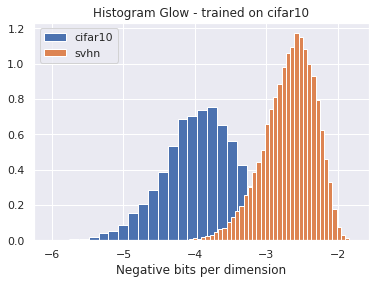

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: data/SVHN/train_32x32.mat
Using downloaded and verified file: data/SVHN/test_32x32.mat
cifar10 NLL tensor(4.1625)
svhn NLL tensor(3.1370)


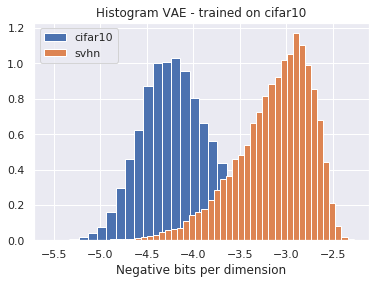

In [6]:
for i, model_name in enumerate(model_name_list):
    hparams = hparams_list[i]
    model_path = model_path_list[i]
    
    image_shape, num_classes, _, test_id = dict_dataset[id_data](hparams['augment'], hparams['dataroot'], hparams['download'])
    image_shape, num_classes, _, test_ood = dict_dataset[ood_data](hparams['augment'], hparams['dataroot'], hparams['download'])
    if model_name=="Glow":
        model = Glow(image_shape, hparams['hidden_channels'], hparams['K'], hparams['L'], hparams['actnorm_scale'],
                 hparams['flow_permutation'], hparams['flow_coupling'], hparams['LU_decomposed'], num_classes,
                 hparams['learn_top'], hparams['y_condition'])
        model.load_state_dict(torch.load(model_path))
        model.set_actnorm_init()
    elif model_name=="VAE":
        model = VAE(image_shape, hparams['hidden_channels'])
        model.load_state_dict(torch.load(model_path))

    model = model.to(device)

    model = model.eval()

    id_nll = compute_nll(test_id, model)
    ood_nll = compute_nll(test_ood, model)

    print(id_data, "NLL", torch.mean(id_nll))
    print(ood_data, "NLL", torch.mean(ood_nll))
    
    plt.figure()
    plt.title("Histogram {} - trained on {}".format(model_name, id_data))
    plt.xlabel("Negative bits per dimension")
    plt.hist(-id_nll.numpy(), label=id_data, density=True, bins=30)
    plt.hist(-ood_nll.numpy(), label=ood_data, density=True, bins=50)
    plt.legend()
    plt.show()